Check whether model can 'think' about a concept that is not related to its input:
    -> think about a specific fruit -> measure different fruit vectors -> ask about what fruit it thought about.

In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import json
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import TokenizeCollator

model_id = "meta-llama/Llama-3.1-8B-Instruct" 
model_id = 'meta-llama/Llama-3.3-70B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id  
tokenizer.padding_side = 'left'

if model_id == 'meta-llama/Llama-3.3-70B-Instruct':
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",    
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,   
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

## Get Concept Vectors

In [2]:
with open("../data/word_concept_extraction.json", 'r') as f:
    word_concept_data = json.load(f)

baseline_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['baseline_words']
]

with open("../data/closed_set_word_concepts.json", 'r') as f:
    closed_set_word_concepts = json.load(f)

mapping = defaultdict(list)
target_chats = []
for i, sample in enumerate(closed_set_word_concepts):
    for item in sample['items']:
        mapping[i].append(len(target_chats))
        target_chats.append(
            [{"role": "user", "content": sample['prompt_template'].format(word=item)}]
        )

control_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['control_words']
]

category_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=f"{category['category']}s")}]
    for category in closed_set_word_concepts
]

num_baseline_samples = len(baseline_chats)
num_target_samples = len(target_chats)
num_control_samples = len(control_chats)
num_category_samples = len(category_chats)
prompts = tokenizer.apply_chat_template(baseline_chats + target_chats + control_chats + category_chats, tokenize=False, add_generation_prompt=True)

concept_cachin_bs = 2
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
concept_vector_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    concept_vector_cache.extend(hidden_states[:, -1])

concept_vector_cache = torch.stack(concept_vector_cache)
baseline_activation = concept_vector_cache[:num_baseline_samples].mean(dim=0)
target_activations = concept_vector_cache[num_baseline_samples: num_baseline_samples + num_target_samples]
control_activations = concept_vector_cache[num_baseline_samples + num_target_samples:num_baseline_samples + num_target_samples + num_control_samples]
category_activations = concept_vector_cache[num_baseline_samples + num_target_samples + num_control_samples:]
concept_vectors = target_activations - baseline_activation
control_vectors = control_activations - baseline_activation
category_vectors = category_activations - baseline_activation

100%|██████████| 136/136 [00:44<00:00,  3.04it/s]


In [3]:
with open("../data/sample_sentences.json", 'r') as f:
    sentence_data = json.load(f)

prompt = "Write '{sentence}'. Please choose one {category} and think about it while you write the sentence. Do not think about other {category}s. Don't write anything else."

chats = []
for sample, sentence in zip(closed_set_word_concepts, sentence_data): # target_words
    chats.append([
        {"role": "user", "content": prompt.format(category=sample['category'], sentence=sentence)},
        {"role": "assistant", "content": sentence},
    ])
prompts = tokenizer.apply_chat_template(chats, tokenize=False)

concept_cachin_bs = 4
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
sentence_hddn_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    for sample_hidden_state, sample_input_ids in zip(hidden_states, batch['input_ids']):
        start_of_response = (sample_input_ids == 271).nonzero()[-1] + 1 # 271 = '\n\n' token which occures just before response in llama3.1
        target_states = sample_hidden_state[start_of_response: -1] # last token is eos so we exclude it
        sentence_hddn_cache.append(target_states)


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


/tmp/ipykernel_3906343/977119655.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, target_mean_df, target_max, concept_df, control_df])


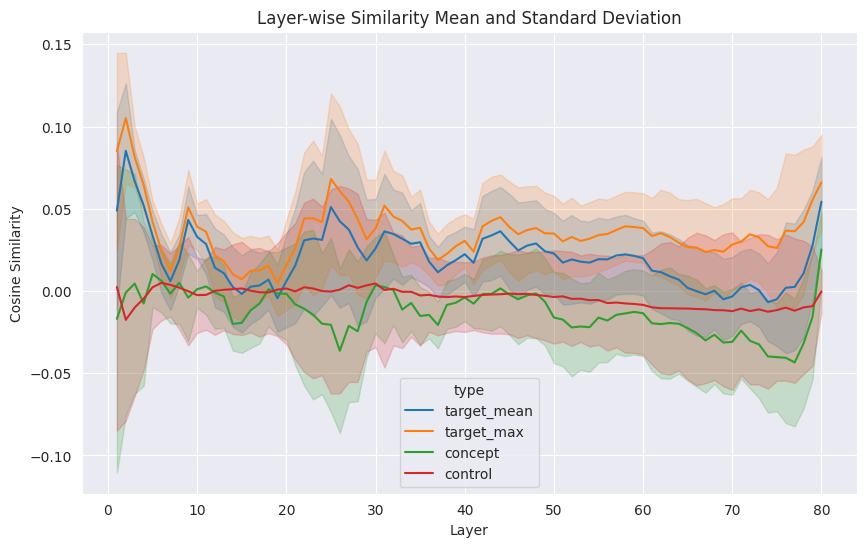

In [5]:
df = pd.DataFrame(columns=['sample', 'layer', 'sim'])
for i, sample_hddn_states in enumerate(sentence_hddn_cache):
    sample_concept_vector_ids = mapping[i]
    sample_concept_vectors = concept_vectors[sample_concept_vector_ids]
    layer_mean_sim = torch.cosine_similarity(sample_hddn_states, sample_concept_vectors[:, None], dim=-1).mean(1)
    mean_layer_mean_sim = layer_mean_sim.mean(0)
    max_layer_mean_sim = layer_mean_sim.max(0).values
    target_mean_df = pd.DataFrame(data={
        'sample': [i] * mean_layer_mean_sim.size(0),
        'layer': list(range(mean_layer_mean_sim.size(0))),
        'sim': mean_layer_mean_sim.float().cpu(),
        'type': 'target_mean'
    })
    target_max = pd.DataFrame(data={
        'sample': [i] * max_layer_mean_sim.size(0),
        'layer': list(range(max_layer_mean_sim.size(0))),
        'sim': max_layer_mean_sim.float().cpu(),
        'type': 'target_max'
    })
    category_vector = category_vectors[i]
    layer_mean_sim = torch.cosine_similarity(sample_hddn_states, category_vector, dim=-1).mean(0)
    concept_df = pd.DataFrame(data={
        'sample': [i] * layer_mean_sim.size(0),
        'layer': list(range(layer_mean_sim.size(0))),
        'sim': layer_mean_sim.float().cpu(),
        'type': 'concept'
    })

    layer_mean_sim = torch.cosine_similarity(sample_hddn_states, control_vectors[:,None], dim=-1).mean(1)
    control_df = pd.DataFrame(data={
        'sample': [i] * layer_mean_sim.size(0) * layer_mean_sim.size(1),
        'layer': list(range(layer_mean_sim.size(1))) * layer_mean_sim.size(0),
        'sim': layer_mean_sim.flatten().float().cpu(),
        'type': 'control'
    })
    df = pd.concat([df, target_mean_df, target_max, concept_df, control_df])
df.reset_index(drop=True, inplace=True)
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='layer', y='sim', hue='type', errorbar='sd')

# Add labels and title
plt.title('Layer-wise Similarity Mean and Standard Deviation')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

# Save or show the plot
plt.show()

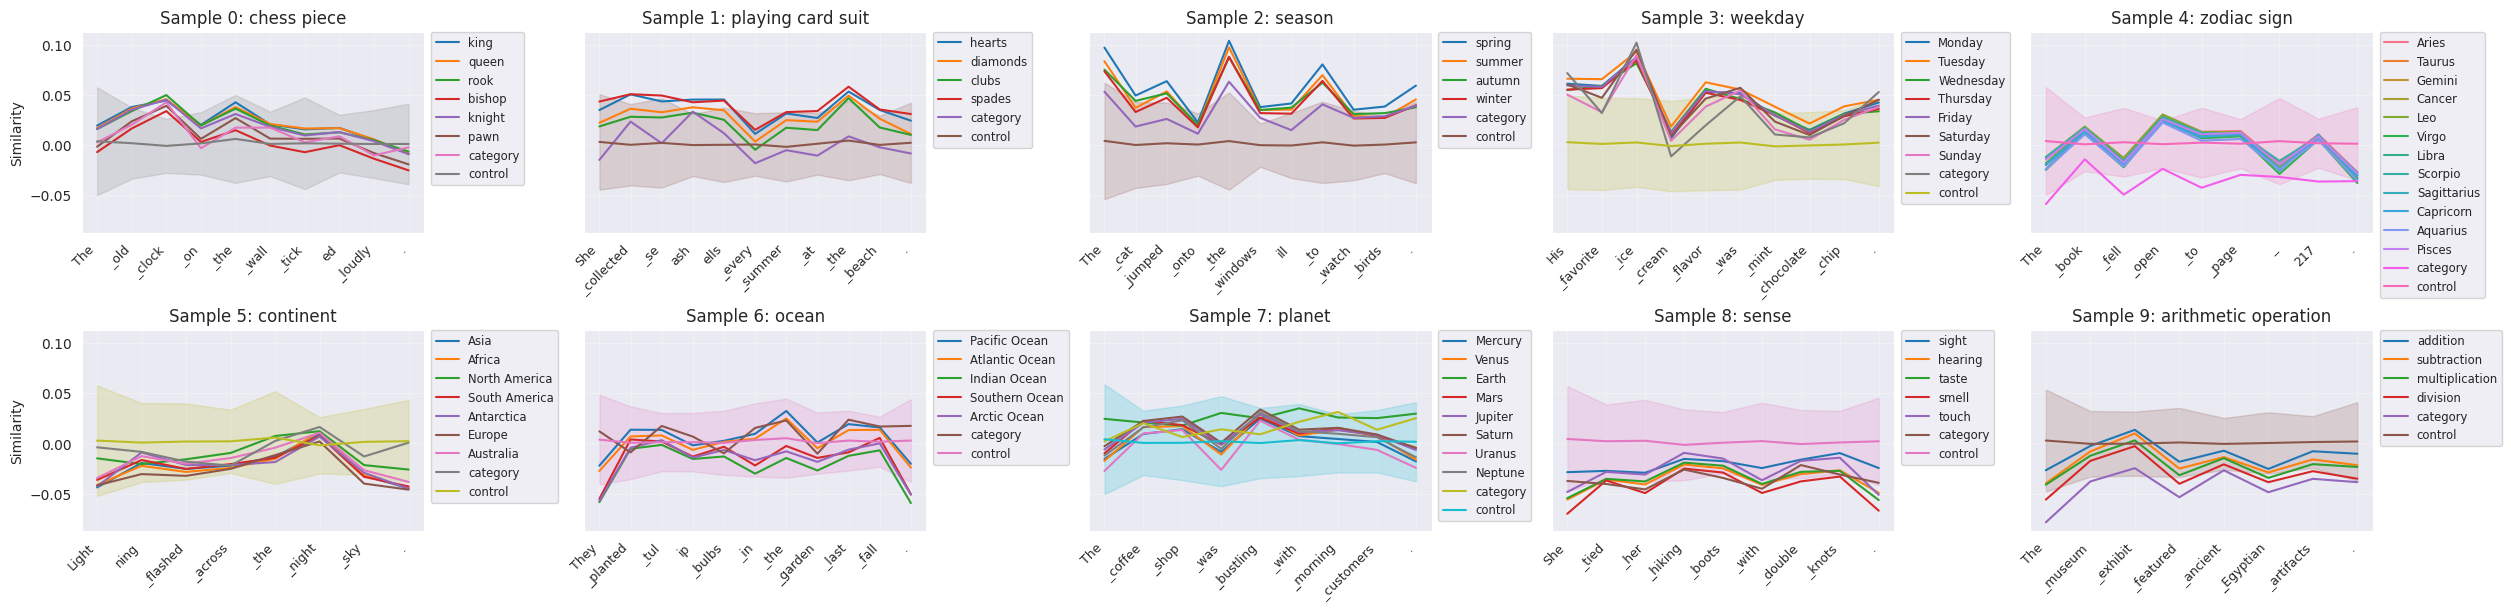

In [6]:
data_list = []
target_layer = 20

# Iterate through your samples
for i, sample_hddn_states in enumerate(sentence_hddn_cache):
    # Calculate similarity: Shape (Tokens, Layers)
    # Assuming sample_hddn_states is (Tokens, Layers, Hidden) based on your .mean(0) usage
    sample_concept_vector_ids = mapping[i]
    sample_concept_vectors = concept_vectors[sample_concept_vector_ids]
    sim_matrix = torch.cosine_similarity(sample_hddn_states, sample_concept_vectors[:, None], dim=-1)
    
    # Extract specific layer data: Shape (Tokens,)
    layer_sims = sim_matrix[:, :, target_layer].float().cpu().numpy()
    words = closed_set_word_concepts[i]['items']

    
    # Store each token's data
    for (sims, word) in zip(layer_sims, words):
        for token_pos, sim in enumerate(sims):
            data_list.append({
                'sample': i,
                'token_pos': token_pos,
                'sim': sim,
                'type': word
            })

    category_vector = category_vectors[i]
    sim_matrix = torch.cosine_similarity(sample_hddn_states, category_vector, dim=-1)
    
    # Extract specific layer data: Shape (Tokens,)
    layer_sims = sim_matrix[:, target_layer].float().cpu().numpy()
    
    # Store each token's data
    for token_pos, sim in enumerate(layer_sims):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'type': 'category'
        })
    
    sim_matrix = torch.cosine_similarity(sample_hddn_states, control_vectors[:,None], dim=-1)
    layer_sims = sim_matrix[:, :, target_layer].float().cpu().numpy()

    for control_sim in layer_sims:
        for token_pos, sim in enumerate(control_sim):
            data_list.append({
                'sample': i,
                'token_pos': token_pos,
                'sim': sim,
                'type': 'control'
            })

df_layer_29 = pd.DataFrame(data_list)

# Setup the grid
fig, axes = plt.subplots(2, 5, figsize=(25, 6), sharey=True, layout='constrained')
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    
    # 1. Plot the data
    category = closed_set_word_concepts[i]['category']
    sample_data = df_layer_29[df_layer_29['sample'] == i]
    
    sns.lineplot(data=sample_data, x='token_pos', y='sim', hue='type', errorbar='sd', ax=ax)
    
    # --- LEGEND FIX ---
    # bbox_to_anchor=(1.02, 1): Places the legend just outside the right edge, aligned to the top
    # loc='upper left': Anchors the top-left corner of the legend box to that point
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')
    
    # 2. Get specific tokens
    sentence = sentence_data[i]
    tokens = tokenizer.tokenize(sentence)
    tokens = [token.replace('Ġ', '_') for token in tokens]
    
    # 3. Formatting
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    
    ax.set_title(f'Sample {i}: {category}')
    ax.grid(True, alpha=0.3)
    
    # Y-axis label only on the left column
    if i % 5 == 0:
        ax.set_ylabel('Similarity')
    else:
        ax.set_ylabel('')
        
    ax.set_xlabel('')

# layout='constrained' (set in subplots above) handles the packing automatically, 
# so plt.tight_layout() is not needed/recommended here.
plt.show()